<center><p float="center">
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center> Real-Time Retail Feedback Intelligence
 </center></h1>


### **Business Context**
The client, which is an online retail company, is facing an increase in customer activity during festive seasons and holiday sales. During this time, the company experiences a surge in customer reviews and feedback. They highlight the importance of minimizing the delay in reading and responding to customer feedback, as it can impact their reputation and customer loyalty.

In the document shared with us, the client has provided, along with the business context and objective of the project, a dataset with a sample of customer reviews and feedback. The dataset is stored in a CSV file and contains information such as the review text and the rating given by the customer so we can develop the system that can process thousands of reviews in real-time and provide insights to the company.

### **Objective**
The objective, as expressed in the shared document, is to build a system based on Generative AI prompt engineering to fulfill the client's goals:

* Analyze and categorize sentiment of the reviews.
* Identify the product or service that the review is referring to.
* Summarize different insights by product type and priority.
* Generate automatic and personalized responses to the customers, taking sentiment into account.
* Generate short, actionable reports for the retail teams.

### **Dataset Used for the Notebook**
The dataset consists of a CSV file with the following columns:

* Clothing.ID: The ID of the clothing item being reviewed.
* Age: The age of the customer who wrote the review.
* Title: The title of the review.
* Review.Text: The text of the review.
* Rating: The rating given by the customer to the product, where 1 is the lowest rank and 5 is the highest.
* Recommended.IND: A binary variable indicating whether the customer recommended the product or not.
* Positive.Feedback.Count: The number of positive feedbacks received by the customer review.
* Division.Name: The name of the division where the product is located.
* Department.Name: The name of the department where the product is located.

### **Installing and Importing Necessary Libraries**
First, let's set up the environment by installing the required Python libraries.

In [103]:
# Install the required libraries for the project
!pip install -q numpy pandas matplotlib seaborn wordcloud openai pydantic 

In [2]:
# Import the required libraries for the EDA
import warnings
warnings.filterwarnings("ignore")

# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

### **Data Loading**
### Loading and Understanding the Data


In [32]:
from pathlib import Path

# Loading the dataset
print("Loading the dataset...")

filepath = Path("Dataset - Real-Time Retail Feedback Intelligence.csv")
if not filepath.exists():
    raise FileNotFoundError(f"The file {filepath} does not exist.")

# Using sep=None and engine='python' to automatically detect the separator
# and handle potential formatting issues that cause ParserError
df = pd.read_csv(filepath, sep=None, engine='python')
print("Dataset loaded successfully.")

Loading the dataset...
Dataset loaded successfully.


### **Data Overview**

In [26]:
# Displaying the first few rows of the dataset
df.head()

,Unnamed: 0,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
0,1,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,2,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,3,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,4,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,5,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [27]:
# Getting summary of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing.ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review.Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended.IND          23486 non-null  int64 
 7   Positive.Feedback.Count  23486 non-null  int64 
 8   Division.Name            23472 non-null  object
 9   Department.Name          23472 non-null  object
 10  Class.Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In the dataset there are 23486 rows and 11 columns.

* The first column is the id of the column, and will be dropped.
* Clothing.ID, Age, Rating and Positive.Feedback.Count are **numeric columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name are **object columns**.
* Title, Review.Text, Division.Name, Department.Name and Class.Name have **missing values**.

### **Sanity checks**

In [35]:
# We will drop the Unnamed column
try:
    df = df.drop(columns=['Unnamed: 0'])
except KeyError as err:
    print("The column 'Unnamed: 0' does was already dropped from the DataFrame.")

# We can use change the Clothing.ID to a categorical variable
df['Clothing.ID'] = df['Clothing.ID'].astype(str)

# We will do the same for the Recommended.IND column
df['Recommended.IND'] = df['Recommended.IND'].astype(str)

The column 'Unnamed: 0' does was already dropped from the DataFrame.


* The Clothing.ID column, although is numeric, will be considered as a categorical variable for the analysis given that it is a unique identifier for each clothing item and does not make sense to analyze it as a numeric variable. The same will be done for the Recommended.ID column.
* We can see that there is a lot of variability among the Title and Review.Text columns. This is ok, due to the nature of the data, which is introduced by users manually with their own words.

### **Data Cleaning and Preprocessing**

In [36]:
# For training purposes will clone de dataframe ignoring the rows where the columns 'Review.Text', 'Division.Name', 'Department.Name' and 'Class.Name' are empty
df_review = df.copy()
df_review = df_review[df_review['Review.Text'].notna() & df_review['Division.Name'].notna() & df_review['Department.Name'].notna() & df_review['Class.Name'].notna()]

# We will check the info of the dataframe after removing the rows
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22628 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing.ID              22628 non-null  object
 1   Age                      22628 non-null  int64 
 2   Title                    19662 non-null  object
 3   Review.Text              22628 non-null  object
 4   Rating                   22628 non-null  int64 
 5   Recommended.IND          22628 non-null  object
 6   Positive.Feedback.Count  22628 non-null  int64 
 7   Division.Name            22628 non-null  object
 8   Department.Name          22628 non-null  object
 9   Class.Name               22628 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.9+ MB


For training and test purposes, we will keep the rows that have all the necessary columns to analyze sentiment and correlate the feedback with the product features.

### **Exploratory Data Analysis**

#### Analyzing summary statistics of numeric columns

In [37]:
# Get a quick overview of the numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,23486.0,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Positive.Feedback.Count,23486.0,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


* The minimum age of the customers is 18 years old, while the maximum es 99. The mean is around 43 years, which is very slightly skewed to the right from the median of 41 years.
* Ratings go from 1 to 5 stars, with a mean of 5. The data is skewed to the left.
* The Possitive.Feedback.Count column has a mean of 2.5 and a standard deviation of 5.7, while the mean is 1. The minimum and maximum values are 0 and 122 respectively. The data is skewed to the right.

#### Analyzing summary statistics on categorical columns

In [40]:
# Get values in each categorical column
categorical_columns = ['Clothing.ID', 'Title', 'Review.Text', 'Division.Name', 'Department.Name', 'Class.Name']
for column in categorical_columns:
    print("=" * 50)
    print("\tAnalyzing column:", column)
    print("=" * 50)
    print("\tUnique values:", df[column].nunique())
    print("\tTop 20 values:", df[column].value_counts().head(20))
    print("\tMissing values:", df[column].isnull().sum())
    print("\tData types:", df[column].dtypes)
    print(2 * "\n")

	Analyzing column: Clothing.ID
	Unique values: 1206
	Top 20 values: Clothing.ID
1078    1024
862      806
1094     756
1081     582
872      545
829      527
1110     480
868      430
895      404
936      358
867      351
850      338
1095     327
863      306
1077     297
1059     294
1086     291
1080     289
860      288
1083     249
Name: count, dtype: int64
	Missing values: 0
	Data types: object



	Analyzing column: Title
	Unique values: 13993
	Top 20 values: Title
Love it!            136
Beautiful            95
Love                 88
Love!                84
Beautiful!           72
Beautiful dress      60
Love it              59
Gorgeous             53
Love this dress!     53
Cute top             52
Disappointed         51
Perfect              49
Great dress          49
Super cute           44
Adorable             43
Great top            42
Not for me           37
Runs small           36
Great top!           35
Great dress!         35
Name: count, dtype: int64
	Missing values: 

From the categorical data, we can see that there is a lot of variability among the Title and Review.Text, which requires a more exhaustive analysis. This will be done in the next sections.

We will focus now on the Clothing.ID, Division.Name, Department.Name and Class.Name columns:
* Clothing.ID: There are 1206 types of articles of clothing in the dataset.
* Division.Name: There 3 different divisions, which are General, General Petite and Initmates (Surely a typo of Intimates).
* Department.Name: The reviews are associated to 6 different departments, that are Tops, Dresses, Bottoms, Intimate, Jackets and Trend.
* Class.Name: There are 20 different classes of articles of clothing. These are:
    * Dresses
    * Knits
    * Blouses
    * Sweaters
    * Pants
    * Jeans
    * Fine gauge
    * Skirts
    * Jackets
    * Lounge
    * Swim
    * Outerwear
    * Shorts
    * Sleep
    * Legwear
    * Intimates
    * Layering
    * Trend
    * Casual bottoms
    * Chemises

#### Distribution of ratings

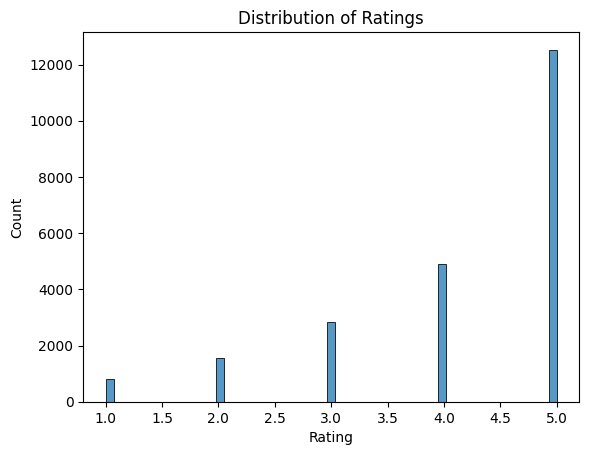

In [ ]:
# Plot distribution of ratings
sns.histplot(df_review['Rating'])
plt.title('Distribution of Ratings')
plt.show()

From the reviews distribution, the standard deviation is around 1 which reflects a distribution that is biased to positive reviews, being 5 the most common rating.

#### Distribution of Ratings among Departments

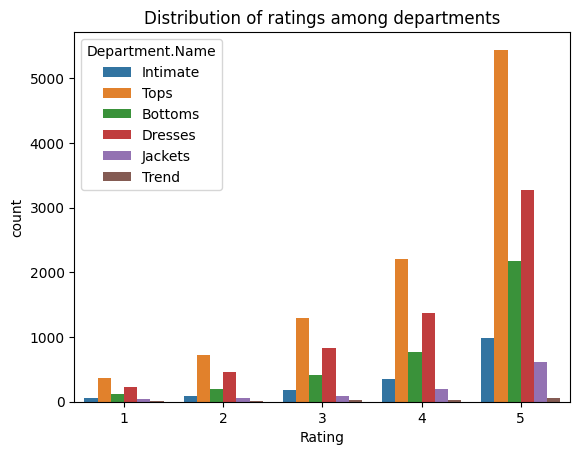

In [53]:
# Checking the distribution of ratings among departments
sns.countplot(data=df_review, x='Rating', hue='Department.Name', )
plt.title('Distribution of ratings among departments')
plt.show()

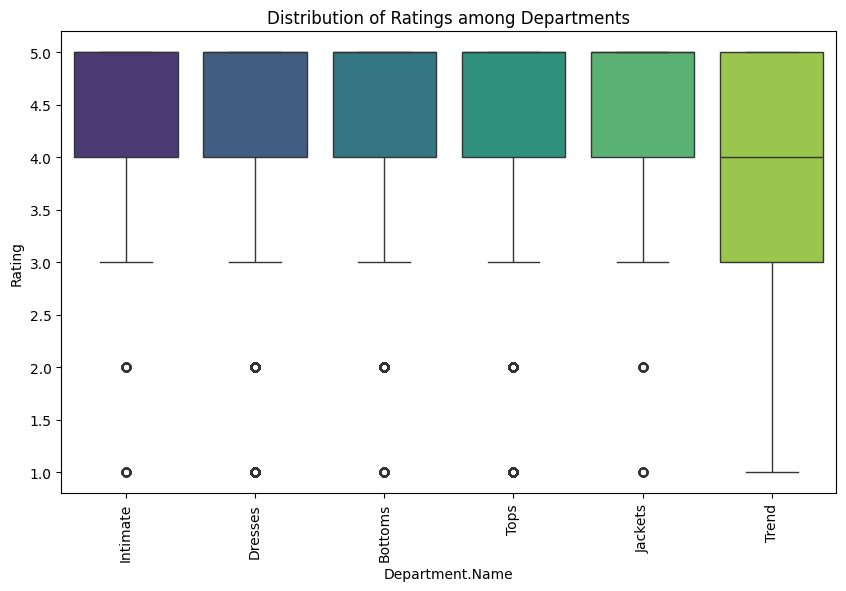

In [56]:
# Usamos boxplot para ver medianas, cuartiles y outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_review, x='Department.Name', y='Rating', palette='viridis')

plt.title('Distribution of Ratings among Departments')
plt.xticks(rotation=90)
plt.show()

The distribution of ratings among departments follows a pattern, where seems to be equally distributed for all the departments, except for the deparment of 'Trend', which has the lowest rating. This could be due to the fact that the amount of activity for this department is too high for the team to handle during these spikes of transactions.

The most rated department is 'Tops', which has the most amount of reviews, although it follows a pattern with the rest of departments along ratings from 1 to 5.

#### Distribution of Common Words in relation with Ratings

Now, we will do a basic analysis on the distribution of words used in the review texts in relation with the rating given by the customers.

In [76]:
# We import the libraries to represent the word distribution in review texts
import re
from wordcloud import WordCloud, STOPWORDS

# We create a set of stopwords to remove common words that do not add value to the word cloud
stopwords = set(STOPWORDS)

In [86]:
# Define a function so we can analyze the word distribution for different ranges of reviews
def plot_word_cloud(text_series, stopwords, title):
    # First we create a text with all the words inside the series
    reviews_text = " ".join(text_series.dropna().astype(str).tolist())

    # Then we remove any special characters and convert the text to lowercase
    reviews_text = re.sub(r"[^a-zA-Z\s]", "", reviews_text)
    reviews_text = reviews_text.lower()

    # Filter out the words that exist inside the stopwords set
    reviews_text = " ".join(word for word in reviews_text.split() if word not in stopwords)

    # Now that the text is cleaned, we can create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(reviews_text)

    # We can then display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

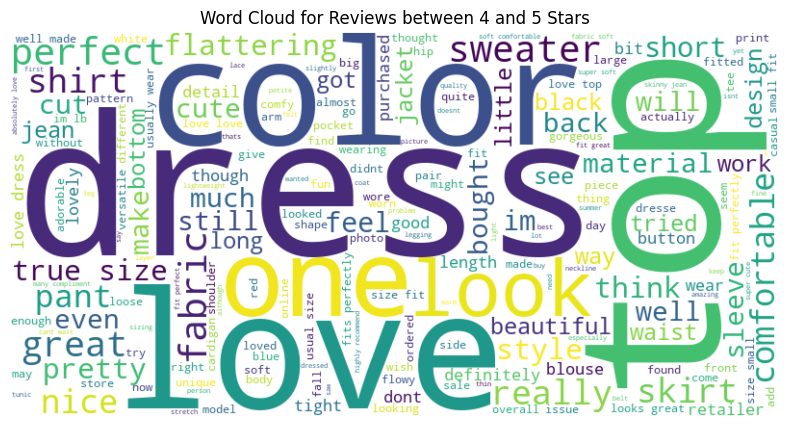

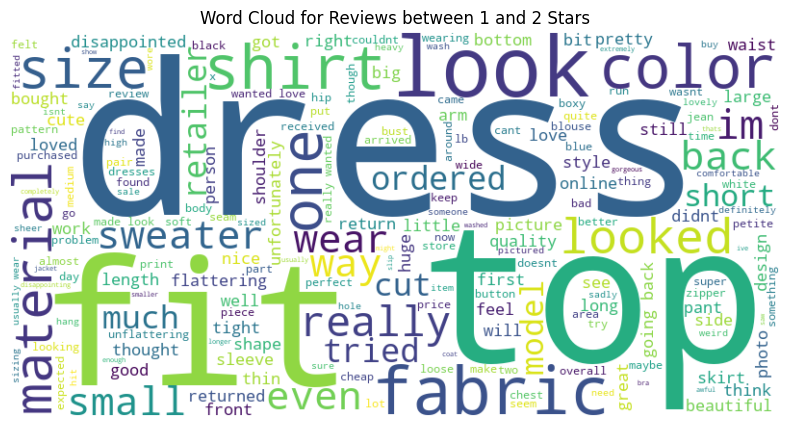

In [82]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

Se ven muchas referencias a palabras que hacen referencia a prendas. Voy a intentar filtrar por adjetivos y volverlo a intentar. Para ello, utilizaremos la librería 'spacy'

In [83]:
# Install spacy and download the English language model
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached charset_normalizer-3.4.4-cp311-cp311-win_amd64.whl.metadata (38 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
   ---------------------------------------- 0.0/15.3 MB ? eta -:--:--
   ------------- -------------------------- 5.2/15.3 MB 35.6 MB/s eta 0:00:01
   ----------------------------- ---------- 11.3/15.3 MB 26.1 MB/s eta 0:00:01
   ---------------------------------------- 15.3/15.3 MB 29.3 MB/s  0:00:00
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached charset_normalizer-3.4.4-cp311-cp311-win_amd64.whl (106 kB)
   ---------------------------------------- 0.0/654.1 kB ? eta -:--:--
   ---------------------------------------- 654.1/654.1 kB 24.5 MB/s  0:00:00
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 32.5 MB/s

In [92]:
# Importing the new library spacy
import spacy

# Loading the model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Increasing the max length of the text
nlp.max_length = 6000000

In [90]:
# Define an improved function for ploting a wordcloud only using adjectives
def plot_word_cloud_adjectives(text_series, stopwords, title):
    # Join all the text in the series and remove special characters
    full_text = " ".join(text_series.dropna().astype(str).tolist())
    full_text = re.sub(r"[^a-zA-Z\s]", "", full_text).lower()

    # Process the text with spaCy
    doc = nlp(full_text)

    # Clean the words
    clean_words = [
        token.lemma_ for token in doc 
        if token.pos_ == "ADJ" and token.lemma_ not in stopwords
    ]
    
    final_text = " ".join(clean_words)

    # If there are no adjectives, return
    if not final_text:
        print(f"No se encontraron adjetivos para el título: {title}")
        return

    # Generate the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(final_text)

    # Plot the wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()

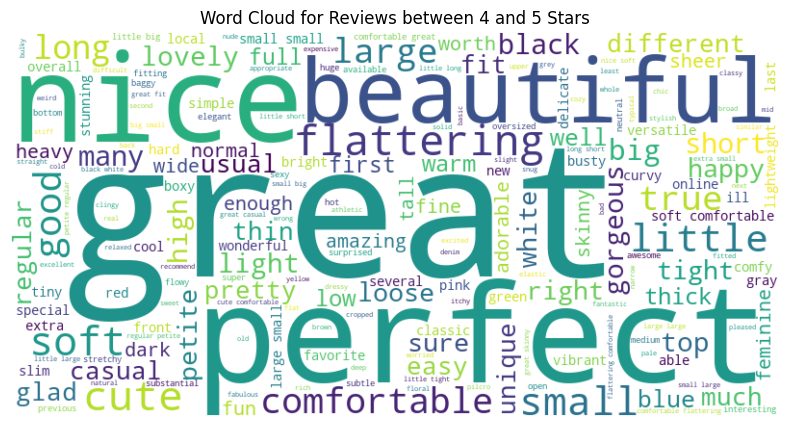

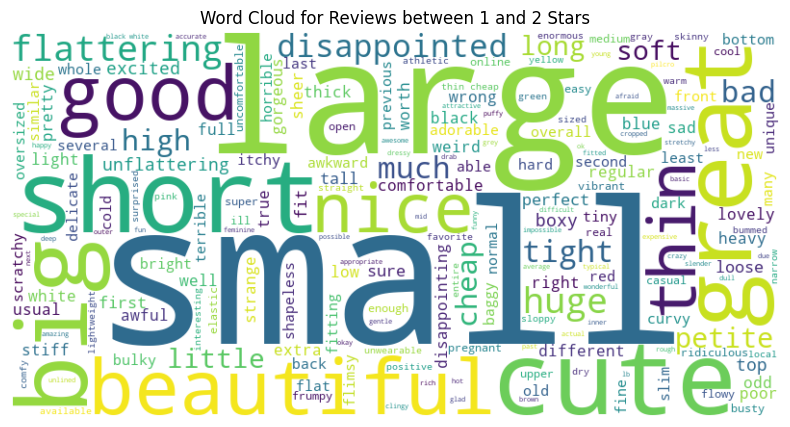

In [93]:
# Analyze word cloud for reviews between 4 and 5 stars
df_review_4_5 = df_review[df_review['Rating'] >= 4]['Review.Text']
plot_word_cloud_adjectives(df_review_4_5, stopwords, title='Word Cloud for Reviews between 4 and 5 Stars')

# Analyze word cloud for reviews between 1 and 2 stars
df_review_1_2 = df_review[df_review['Rating'] <= 2]['Review.Text']
plot_word_cloud_adjectives(df_review_1_2, stopwords, title='Word Cloud for Reviews between 1 and 2 Stars')

For analyzing the most common words in reviews between 4 and 5 and between 1 and 2, we used two approaches: filter words for each range of ratings and filter adjectives for each range of ratings.

Looking at both approaches for generating word clouds, we can see:

* For ratings between 4 and 5: 
    * For the first approach, 'Love' is a word that comes to the eyes. There are also references to clothe types, such as 'dress', 'tops', which do not give insight about the sentiment of the review, but can be helpful for determining the type of product - also we see references about 'color', 'material' and 'fabric'
    * For the second approach we can see 'great', 'beautiful', 'perfect', 'soft', 'comfortable', 'flattering'.

* For ratings between 1 and 2:
    * For the first approach we also see 'dress', 'tops' and other clothing types, and is harder to identify any relation with the sentiment of the review.
    * For the second approach, there are references to the sizes of cloth, like 'small', 'large', 'short', 'big', but also references to words that relate to good sentiments like good, beautiful. There are some evident words that relates to bad reviews like disappointed and scratchy that are mildly visible.


From this preliminar analysis, we can see that there is some ambiguity in most common words if we want to releate them to sentiment. But it can be useful to determine the clothing type and hints on characteristics that are important for the customer.

## **Building the Generative AI Pipeline**

We will now build a system to analyze the reviews. This involves setting up the AI client, designing prompts, generating structured data, and evaluating the results.

#### **Setup AI Client and Data Sample**

**Questions:**

1.  How do you initialize the OpenAI client with your API key and the correct base URL?
    

#### **Note:**

For this project, we will analyze and categorize a sample of **50 customer reviews**. This number is chosen intentionally. Since the API has a **budget limit of $20**, running prompts on very large datasets can quickly exhaust your quota—especially because this exercise may involve **multiple iterations, prompt refinements, and repeated evaluations**.

To avoid unnecessary cost and ensure efficient experimentation, we recommend the following approach:

*   **Use very small samples (5–10 reviews)** during the **initial testing phase** to validate your prompt structure and logic.
    
*   **Scale up to 50 reviews** for the **final evaluation phase**, ensuring you get enough data to compare prompting techniques without draining your budget.
    
*   This strategy helps maintain cost control while still providing meaningful insights across Zero-Shot, Few-Shot, and Chain-of-Thought techniques.
    

If your API quota gets exhausted, you may temporarily switch to another free AI assistant API. However, note that external tools may also have **rate limits** or **token caps**, so you will need to build retry logic and manage throttling within your code.

In [95]:
# Import the necesary libraries to initialize the OpenAI client
import os
import json
from openai import OpenAI

In [98]:
# Load the API key from the JSON file
print("Loading API key from JSON file...")
with open('api_key.json', 'r') as f:
    api_key_file_info = json.load(f)

gl_openai_api_key = api_key_file_info['openai_api_key']
gl_openai_base_url = api_key_file_info['openai_base_url']
gl_openai_model = api_key_file_info['openai_model']

# Initialize the OpenAI client
print("Initializing OpenAI client...")
client = OpenAI(api_key=gl_openai_api_key, base_url=gl_openai_base_url)

print("API key loaded successfully. ")


Loading API key from JSON file...
Initializing OpenAI client...
API key loaded successfully. 


In [102]:
# List the top 5 models
print("List of available models:")
models = client.models.list()
model_ids = [model.id for model in list(models)[:]]

for name in model_ids:
    print(f"- {name}")

List of available models:
- gpt-4-0613
- gpt-4
- gpt-3.5-turbo
- chatgpt-image-latest
- gpt-4o-mini-tts-2025-03-20
- gpt-4o-mini-tts-2025-12-15
- gpt-realtime-mini-2025-12-15
- gpt-audio-mini-2025-12-15
- davinci-002
- babbage-002
- gpt-3.5-turbo-instruct
- gpt-3.5-turbo-instruct-0914
- dall-e-3
- dall-e-2
- gpt-4-1106-preview
- gpt-3.5-turbo-1106
- tts-1-hd
- tts-1-1106
- tts-1-hd-1106
- text-embedding-3-small
- text-embedding-3-large
- gpt-4-0125-preview
- gpt-4-turbo-preview
- gpt-3.5-turbo-0125
- gpt-4-turbo
- gpt-4-turbo-2024-04-09
- gpt-4o
- gpt-4o-2024-05-13
- gpt-4o-mini-2024-07-18
- gpt-4o-mini
- gpt-4o-2024-08-06
- chatgpt-4o-latest
- gpt-4o-audio-preview
- gpt-4o-realtime-preview
- omni-moderation-latest
- omni-moderation-2024-09-26
- gpt-4o-realtime-preview-2024-12-17
- gpt-4o-audio-preview-2024-12-17
- gpt-4o-mini-realtime-preview-2024-12-17
- gpt-4o-mini-audio-preview-2024-12-17
- o1-2024-12-17
- o1
- gpt-4o-mini-realtime-preview
- gpt-4o-mini-audio-preview
- computer-use

**Helper functions**

Before going further, we will define some useful functions and structures to test our prompts. The objective is to create at least one function for each of the following tasks:

1. Generate the responses for single rows
2. Evaluate the responses for single rows
3. Generate and evaluate the responses for multiple rows (full flow)

As for best practices, these funtions will try to be sufficiently restrictive in the output format, using pydantic, but also generic so we can use them for the different prompting techniques we will try.

In [117]:
# This library is used to parse the response from OpenAI
from pydantic import BaseModel
from typing import Literal


# We will use pydantic to define the response format and save us the step of parsing the response
class ReviewAnalysis(BaseModel):
    product_category: Literal["Dresses", "Knits", "Blouses", "Sweaters", "Pants", "Jeans", "Fine gauge", "Skirts", "Jackets", "Lounge", "Swim", "Outerwear", "Shorts", "Sleep", "Legwear", "Intimates", "Layering", "Trend", "Casual bottoms", "Chemises"]
    sentiment: Literal["positive", "negative", "neutral"]
    summary: str
    personalized_message: str
    retail_insight: str


# Define a function to process the review. This function will be used for all prompting techniques
def process_review(openai_client: OpenAI, system_prompt: str, review_text: str, model: str = "gpt-4o-mini") -> dict:
    """
    Process a review using OpenAI's GPT-4o-mini model. 

    Args:
        openai_client (OpenAI): The OpenAI client.
        system_prompt (str): The system prompt to use for the review.
        review_text (str): The review text to process.
        assistant_prompt (list, optional): The assistant prompt to use for the review. Defaults to [].
        model (str, optional): The model to use for the review. Defaults to "gpt-4o-mini".
    
    Returns:
        dict: The response from the OpenAI model.
    """

    try:
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Analyze the following review: {review_text}"},
        ]

        # Parse the response using pydantic
        response = openai_client.beta.chat.completions.parse(
            model=model,
            messages=messages,
            response_format=ReviewAnalysis,
        )
        return response.choices[0].message.parsed
    except Exception as e:
        print(f"Error processing review: {e}")
        return None    


Now we will test the function and structured response with a smoke test prompt.

In [119]:
smoke_test_prompt = "You are a retail expert from customer service"
smoke_test_review = "This shirt is so comfy and soft!"

# After defining the process_review function, we will test it with a simple example
smoke_test = process_review(
    openai_client=client, 
    system_prompt=smoke_test_prompt, 
    review_text=smoke_test_review
)

print(smoke_test)

product_category='Blouses' sentiment='positive' summary='The customer finds the shirt to be very comfortable and soft, indicating a high level of satisfaction with the product.' personalized_message="Thank you for sharing your positive experience! We're thrilled to hear that you find the shirt comfy and soft. We hope you enjoy wearing it!" retail_insight='Comfort and softness are key attributes that customers look for in blouses. Highlighting these features in marketing can enhance product appeal.'


We are also going to define a function to evaluate the model responses. For this, we will use a hybrid evaluation metric, combining category comparison with ground truth values and LLM-as-a-Judge (LLM-Judge) to measure the quality of the responses.

The evaluation parameters for the response will be as follows:

* Category Comparison: We will compare the predicted category with the ground truth category to measure the accuracy of the model. (0.3 points)

* LLM-Judge: We will use the LLM-Judge to measure the quality of the responses. The LLM-Judge will be used to evaluate the responses based on the following criteria: (0.7 points total)

    * Factuality: The response should be verifiable. (0.30 points)
    * Relevance: The response should actually answer the question. (0.20 points)
    * Clarity: The response should be clear and easy to understand. (0.10 points)
    * Efficiency: The response should be concise and provide the necessary information without being too long. (0.10 points)

    

In [ ]:
from pydantic import Field, validator

class JudgeEvaluation(BaseModel):
    relevance: float = Field(description="Does the response address the original review? 10 = Perfect, 0 = No relevance", ge=0, le=10)
    factuality: float = Field(description="Is the response verifiable against the original review and context? 10 = Perfect, 0 = No factuality", ge=0, le=10)
    clarity: float = Field(description="Is the response clear and easy to understand? 10 = Perfect, 0 = No clarity", ge=0, le=10)
    structure: float = Field(description="Is the response well-structured? 10 = Perfect, 0 = No structure", ge=0, le=10)
    hallucination_detected: bool = Field(description="Is the model making up information that is not in the original review or context?")
    justification: str = Field(description="Justification for the evaluation score.")

    @validator("relevance", "factuality", "clarity", "structure")
    def check_score_range(cls, v):
        if v < 0 or v > 10:
            raise ValueError("Score must be between 0 and 10")

        # We will convert the score to a float between 0 and 1
        return v / 10


def get_judge_evaluation(openai_client: OpenAI, original_review: str, true_category: str, response: ReviewAnalysis, model: str = "gpt-4o-mini") -> JudgeEvaluation:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        openai_client: OpenAI client instance.
        original_review: Original review text.
        true_category: True category of the review.
        response: ReviewAnalysis object containing the response.
        model: Model to use for evaluation.

    Returns:
        JudgeEvaluation: Evaluation object containing the score and justification.
    """
    # Transform the response to a dictionary so the model can read it
    response_dict = response.model_dump()

    # Generate the response
    response = openai_client.beta.chat.completions.parse(
        model=model,
        messages=[
            {"role": "system", "content": "You are an AI quality evaluator basing your criteria on the following: relevance, factuality, clarity and structure."},
            {"role": "user", "content": f"Original review: {original_review}\nTrue category: {true_category}\nReview Analysis: {response_dict}"}
        ],
        response_format=JudgeEvaluation,
    )

    # Return the score
    return response.choices[0].message.parsed


def calculate_total_score(judge_evaluation: JudgeEvaluation, true_category: str, response: ReviewAnalysis) -> float:
    """
    Evaluate the quality of the response generated by the model.

    Args:
        judge_evaluation: JudgeEvaluation object containing the score and justification.
        true_category: True category of the review.
        response: ReviewAnalysis object containing the response.

    Returns:
        float: Total score of the response.
    """
    # Calculating the consistency comparing directly the true category with the predicted category
    consistency = 1.0 if true_category.lower() == response.product_category.lower() else 0.0

    # Calculate the efficiency of the response, penalizing if the message is too long
    efficiency = 1.0 if len(response.personalized_message) < 100 and len(response.retail_insight) < 100 else 0.4

    # Defining weights for the criteria
    weights = {
        "consistency": 0.3,
        "factuality": 0.3,
        "relevance": 0.2,
        "clarity": 0.1,
        "efficiency": 0.1
    }

    # Calculate the total score
    total_score = (
        weights["consistency"] * consistency +
        weights["factuality"] * judge_evaluation.factuality +
        weights["relevance"] * judge_evaluation.relevance +
        weights["clarity"] * judge_evaluation.clarity +
        weights["efficiency"] * efficiency
    )

    return round(total_score, 4)

In [ ]:
# Evaluating smoke test result
smoke_test_evaluation = get_judge_evaluation(client, smoke_test_review, "blouses", smoke_test)

In [146]:
print("Judge evaluation: ")
print(smoke_test_evaluation)

Judge evaluation: 
relevance=1.0 factuality=1.0 clarity=1.0 structure=1.0 hallucination_detected=False justification="The response directly addresses the sentiments expressed in the original review, highlighting comfort and softness which are explicitly mentioned. The summary accurately reflects the content of the review, and the personalized message reinforces the positive sentiment. The retail insight is relevant and adds value, aligning with the customer's attributes of interest."


In [147]:
# Calculate smoke test score
smoke_test_score = calculate_total_score(smoke_test_evaluation, "blouses", smoke_test)
print("Smoke test score: ", smoke_test_score)

Smoke test score:  0.94


**Sample Preparation**

Now that we have defined the basic functions for the model testing, we will prepare a function that randomly selects N reviews, making sure we have a mix of positive and negative reviews and covering different product categories.

In [166]:
def get_balanced_sample(df, n=15, balance_threshold=4):
    """
    Samples reviews from the dataframe until a balanced distribution of ratings is found
    based on the harmonic mean of positive, negative, and neutral counts.
    """
    random_state = 1
    while True:
        df_sample = df.sample(n=n, random_state=random_state)

        # Count frequencies of each rating category
        positive_rating = len(df_sample[df_sample['Rating'] > 3])
        negative_rating = len(df_sample[df_sample['Rating'] < 3])
        neutral_rating = len(df_sample[df_sample['Rating'] == 3])

        # Check for any zero counts to avoid division by zero in harmonic mean
        if positive_rating == 0 or negative_rating == 0 or neutral_rating == 0:
            counts = [0.1, 0.1, 0.1]
        else:
            counts = [positive_rating, negative_rating, neutral_rating]

        # Calculate harmonic mean
        harmonic_mean = len(counts) / sum(1 / count for count in counts)
        
        if harmonic_mean >= balance_threshold:
            return df_sample, random_state
        
        random_state += 1

In [171]:
# Execute the refactored function
df_preliminar_sample, random_state = get_balanced_sample(df_review)

# Print results
print("Random state:", random_state)
print(df_preliminar_sample['Rating'].value_counts())
df_preliminar_sample.head()

Random state: 56
Rating
5    5
2    4
3    3
4    2
1    1
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
11998,602,36,Not what i expected,This romper was not what i expected when i ori...,3,0,0,General,Bottoms,Shorts
20437,1081,53,Not what i had hoped for,On a positive note the dress was very well mad...,2,0,1,General,Dresses,Dresses
6827,384,30,Very nice,"I'm not sure what cup size i am, 36b or 36c, b...",5,1,0,Initmates,Intimate,Intimates
19945,514,46,"Cute design, impossible fit",I tried this on in my regular size and was abl...,2,0,9,Initmates,Intimate,Swim
3446,841,35,Not as expected,"In paper crown dresses, i wear a small or size...",2,0,11,General Petite,Tops,Blouses


In [178]:
# Execute the refactored function
df_final_sample, random_state = get_balanced_sample(df_review, n=50, balance_threshold=14)

# Print results
print("Random state:", random_state)
print(df_final_sample['Rating'].value_counts())
df_final_sample.head()

Random state: 1357
Rating
5    22
3    11
2     9
1     4
4     4
Name: count, dtype: int64


,Clothing.ID,Age,Title,Review.Text,Rating,Recommended.IND,Positive.Feedback.Count,Division.Name,Department.Name,Class.Name
20038,895,36,NaN,"This sweater is so lovely, i bought it first i...",5,1,0,General,Tops,Fine gauge
8486,895,35,Not for me...,"On me, this top is totally frumpy and boxy. i ...",2,0,4,General,Tops,Fine gauge
11067,866,38,Beautiful peplum!,"I absolutely adore peplum tops, although some ...",5,1,9,General,Tops,Knits
14361,935,35,Poor quality,I ordered this cardigan on sale and it was a w...,2,0,0,General,Tops,Sweaters
22463,1131,28,Too large and low quality,I wanted to like this coat so bad! i loved the...,2,0,0,General Petite,Jackets,Outerwear


We implemented a brute force algorithm to find a mildly balanced sample of the dataset, asuming there is a correlation between the rating and the sentiment of the review, resulting in:

* Preliminar sample (df_preliminar_sample) of 15 reviews with 5 'negative' reviews (less than 3), 7 possitives (greater than 3) and 3 neutral reviews (equal to 3).
* Final sample (df_final_sample) of 50 reviews with 13 'negative' reviews (less than 3), 26 possitives (greater than 3) and 11 neutral reviews (equal to 3).

#### **Prompt Engineering and Evaluation**

We will test three different prompting techniques. For each, we will create a basic version (V1) and an enhanced version (V2).

**Think about it:** Why is it important to have a consistent and robust evaluation framework? How can we use an "LLM-as-Judge" to score the quality of our generated outputs objectively?

#### **Technique 1: Zero-Shot Prompting**

**Questions:**

1.  How would you design a basic Zero-Shot prompt that asks the model for Category, Sentiment, Summary, Personalized Message, and Retail Insight?
    
2.  How can you enhance this prompt with more business context (e.g., a company name, the importance of accuracy) to create a V2 prompt?
    
3.  How will you loop through the data sample to generate and store the structured output for both prompt versions?
    
4.  How will you apply the LLM-as-Judge to generate a evaluation score between 0 to 1 (decimal allowed) for the outputs and calculate the average score of V1 and V2 prompt?

**How the process works:**

1.  First, you create an **LLM-as-a-judge** function that can evaluate the quality of model outputs.
    
2.  Then, you run your **Zero-Shot Prompt Version 1** on a sample of 100 reviews to generate predictions.
    
3.  You use the judge function to **score each prediction** and compute the **average score for Version 1**.
    
4.  Next, you repeat the same workflow with your **Version 2 prompt**, generate predictions, evaluate them, and calculate the **average score for Version 2**.

**Preliminar Analysis**

During this phase we are going to test basic prompts using zero-shot techniques, so we can validate the quality of the responses and select the first version of the system.

In [ ]:
# We will start with the simplest prompt. The same that we used for the smoke test before
v1_zero_shot_promt = "You are a retail expert from customer service"


#### **Technique 2: Few-Shot Prompting**

**Questions:**

1.  How do you structure a Few-Shot prompt? What kind of examples (e.g., one positive, one negative) would be most effective?
    
2.  For the V2 prompt, how can you add a set of "rules" to guide the model's output for each field, reducing ambiguity?
    
3.  After generating and scoring the outputs, how does the performance of Few-Shot prompting compare to previous version?

**How the process works:**

1.  First, you create an **LLM-as-a-judge** function that can evaluate the quality of model outputs.
    
2.  Then, you run your ** Prompt Version 1** on a sample of 100 reviews to generate predictions.
    
3.  You use the judge function to **score each prediction** and compute the **average score for Version 1**.
    
4.  Next, you repeat the same workflow with your **Version 2 prompt**, generate predictions, evaluate them, and calculate the **average score for Version 2**.

#### **Technique 3: Chain-of-Thought (CoT) Prompting**

**Questions:**

1.  How do you instruct the model to "think step-by-step" internally but only show the final, structured answer?
    
2.  How can you combine the CoT instruction with more detailed reasoning from the COT V1 prompt to create a powerful CoT V2 prompt?
    
3.  Does encouraging the model to reason first lead to a measurable improvement in the quality of the generated insights?

**How the process works:**

1.  First, you create an **LLM-as-a-judge** function that can evaluate the quality of model outputs.
    
2.  Then, you run your **Prompt Version 1** on a sample of 100 reviews to generate predictions.
    
3.  You use the judge function to **score each prediction** and compute the **average score for Version 1**.
    
4.  Next, you repeat the same workflow with your **Version 2 prompt**, generate predictions, evaluate them, and calculate the **average score for Version 2**.

## **Applying GenAI for Product Recommendation:**

Now, let's use the model for a different task: predicting the Recommended IND flag.

**Questions:**

1.  How do you design a prompt that strictly asks for a binary output (1 or 0) and a brief reason?
    
2.  What kind of function is needed to reliably parse the model's text response to extract the 1/0 flag and the Reason?
    
3.  How do you evaluate the model's performance as a classifier using standard metrics like accuracy, confusion matrix, and classification report?

**How the Process Works**


**1\. Prepare Data**

Copy the dataset, store the original recommendation labels, and remove them from the model input to avoid leakage.

**2\. Generate Predictions**

Use a strict two-line prompt to make the LLM output a binary recommendation (1/0) and a short reason based only on the review text.

**3\. Parse Outputs**

Extract the flag and reason from the raw LLM response using regex-based parsing that handles formatting issues.

**4\. Build Prediction Table**

Run the prompt for each review, parse the result, and store the predictions in a new DataFrame.

 **5\. Evaluate Performance**

Compare LLM predictions with true labels using accuracy, confusion matrix, and classification report.

 **6\. Explain Mismatches**

For incorrect predictions, generate a short explanation describing why the model’s decision may have differed from the human label.

**Visualization of Sentiments Distribution**

 After generating results from all prompting techniques, it's crucial to visualize their outputs to better understand their behavior and performance. This helps us see if one technique tends to be more cautious (e.g., assigning more 'Neutral' sentiments) or if they generally agree on the sentiment of the reviews.
    
 **Questions:**
    
* How does the distribution of predicted Sentiment (Positive, Negative, Neutral) compare across the V2 versions of Zero-Shot, Few-Shot, and Chain-of-Thought? (Hint: Create a separate bar chart for each technique's V2 sentiment column).
    
* Are there noticeable differences in the counts? For example, does one technique identify more "Neutral" reviews than the others? What might this imply about its ability to handle nuance?
    


##  **Comparison of Prompting Techniques:**
    
   *   How do the three techniques (Zero-Shot, Few-Shot, CoT) compare in terms of their responses. Use LLM to give verdict?
        
  *   Which technique was the most reliable and consistent? Why do you think it performed the best?
        
   *   What model and prompt design would you propose for a production environment?
        


### **Observations and Insights**

 **Refined Insights:**
    
   *   What are the most meaningful and recurring insights from the customer reviews, as identified by your best-performing model?

# Generating Actionable Product Improvement Suggestions


 *   Based on the aggregated insights from your best model, what are 3 short-term (3-6 months) and 3 long-term (6-12 months) actionable business recommendations for the retail company?
        
 *   How does this automated GenAI pipeline solve the initial business problem and create value?

### **Observations and Insights**

## **Conclusion**